We want to:
- Load the extracted information from X, Bluesky, and Reddit data
- Cluster these to get entity membership

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import io
import json
import os
import pickle
import re
import uuid

from itertools import product 

from tqdm import tqdm

from sentence_transformers import SentenceTransformer

from sklearn.cluster import AgglomerativeClustering, \
    MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

/nas/ckgfs/users/eboxer/complexdata/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.set_option('display.max_columns', 100)

# Load data
From my and Ardy's extractions

In [3]:
def default_loads(text) -> dict:
    # json.loads with default value for empty values
    if len(text) == 0:
        return {}
    return json.loads(text)

In [4]:
data_dir = './data/consolidated'
fnames = os.listdir(data_dir)
for fname in fnames:
    new_object_name = '_'.join(fname.split('_')[:2])
    globals()[new_object_name] = pd.read_csv(os.path.join(data_dir, fname))
    print(new_object_name, ':', globals()[new_object_name].shape)

interactions_x : (385208, 5)


/tmp/ipykernel_172034/1981963069.py:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  globals()[new_object_name] = pd.read_csv(os.path.join(data_dir, fname))


posts_x : (368354, 34)
users_x : (17933, 24)
interactions_bluesky : (460458, 6)


/tmp/ipykernel_172034/1981963069.py:5: DtypeWarning: Columns (14,18) have mixed types. Specify dtype option on import or set low_memory=False.
  globals()[new_object_name] = pd.read_csv(os.path.join(data_dir, fname))


posts_bluesky : (349796, 27)
users_bluesky : (274495, 10)


## Reddit

In [5]:
path = './data/intermediate_kg/narrative_v2_ent_obj_deduplicated.json'
df_reddit = pd.read_json(path).T.reset_index()
df_reddit = df_reddit.rename(columns={'index': 'record_id'})
print(df_reddit.shape)
df_reddit[:3]

(279, 6)


,record_id,text,score,created_utc,permalink,political_narratives
0,1irkxfo,https://preview.redd.it/l51lcf6fkpje1.jpg?widt...,1,1739802140.0,https://www.reddit.com/r/canadaleft/comments/1...,"[{'name': 'Doug Ford', 'action_or_role': 'dism..."
1,1izj6zk,"When we make claims like that, we have to take...",1,1740672206.0,https://www.reddit.com/r/CanadianConservative/...,[]
2,1iugb8j,"Since Kash was confirmed today, republicans no...",2,1740105329.0,https://www.reddit.com/r/Conservative/comments...,"[{'name': 'Kash Patel', 'action_or_role': 'Con..."


In [6]:
# Normalize the extractions
df_reddit = df_reddit.explode(['political_narratives']).reset_index(drop=True)
print('Exploded:', df_reddit.shape)
df_reddit = df_reddit.drop(columns=['political_narratives']).join(
    pd.json_normalize(df_reddit['political_narratives'])
)
print('Normalized:', df_reddit.shape)
df_reddit[:3]

Exploded: (919, 6)
Normalized: (919, 10)


,record_id,text,score,created_utc,permalink,name,action_or_role,affected_entities,narrative,sentiment
0,1irkxfo,https://preview.redd.it/l51lcf6fkpje1.jpg?widt...,1,1739802140.0,https://www.reddit.com/r/canadaleft/comments/1...,Doug Ford,dismantling Ontario,ontario residents,The narrative suggests a critical view of Doug...,negative
1,1irkxfo,https://preview.redd.it/l51lcf6fkpje1.jpg?widt...,1,1739802140.0,https://www.reddit.com/r/canadaleft/comments/1...,Duncan Kinney,outgoing editor-in-chief of The Progress Report,readers,The narrative reflects a sense of loss and app...,positive
2,1irkxfo,https://preview.redd.it/l51lcf6fkpje1.jpg?widt...,1,1739802140.0,https://www.reddit.com/r/canadaleft/comments/1...,Duncan Kinney,outgoing editor-in-chief of The Progress Report,followers of the progress report,The narrative reflects a sense of loss and app...,positive


In [7]:
# Clean up sentiment
def clean_sentiment(text) -> int:
    if text == 'negative':
        return -1
    elif text == 'neutral':
        return 0
    elif text == 'positive':
        return 1
    return text
df_reddit.loc[:, 'sentiment'] = df_reddit['sentiment'].apply(clean_sentiment)
df_reddit['sentiment'].value_counts(dropna=False)

sentiment
-1.0    383
 1.0    364
 0.0     96
 NaN     76
Name: count, dtype: int64

In [8]:
# Rename in agreement with my extractions
df_reddit = df_reddit.rename(columns={
    'name': 'agent_norm',
    'action_or_role': 'action_or_event_norm',
    'affected_entities': 'object_norm',
    'narrative': 'narrative',
})

## Bluesky

In [9]:
path = './data/processed/gpt4omini_posts_bluesky_20250301_20250314_extractions_zeroshot.pkl'
with open(path, 'rb') as f:
    id2processed_text = pickle.load(f)
id2processed_text = {id_: default_loads(text).get('events', []) for id_, text in id2processed_text.items()}
print(len(id2processed_text))

23872


In [10]:
df_bluesky = pd.DataFrame({
    'record_id': id2processed_text.keys(),
    'political_narratives': id2processed_text.values(),
})
print(df_bluesky.shape)
df_bluesky[:3]

(23872, 2)


,record_id,political_narratives
0,at://did:plc:24mnsbrqf2z3eois4q4yxenw/app.bsky...,"[{'agent': 'Carney', 'agent_norm': 'Carney', '..."
1,at://did:plc:26okds6jkoyhx7zkgqo5iwgj/app.bsky...,"[{'agent': 'Jagmeet Singh', 'agent_norm': 'Jag..."
2,at://did:plc:2nlz6ge4fvmed2vbeh5lqemn/app.bsky...,"[{'agent': 'User', 'agent_norm': 'User', 'acti..."


In [11]:
# Normalize the extractions
df_bluesky = df_bluesky.explode(['political_narratives']).reset_index(drop=True)
print('Exploded:', df_bluesky.shape)
df_bluesky = df_bluesky.drop(columns=['political_narratives']).join(
    pd.json_normalize(df_bluesky['political_narratives'])
)
print('Normalized:', df_bluesky.shape)
df_bluesky[:3]

Exploded: (38870, 2)
Normalized: (38870, 8)


,record_id,agent,agent_norm,action_or_event,action_or_event_norm,object,object_norm,narrative
0,at://did:plc:24mnsbrqf2z3eois4q4yxenw/app.bsky...,Carney,Carney,find new blood to run with him,find new candidates,the party,the party,Carney is expected to recruit new candidates f...
1,at://did:plc:26okds6jkoyhx7zkgqo5iwgj/app.bsky...,Jagmeet Singh,Jagmeet Singh,criticizing,criticize,NDP,New Democratic Party,Jagmeet Singh criticizes the NDP for betraying...
2,at://did:plc:26okds6jkoyhx7zkgqo5iwgj/app.bsky...,Canadians,Canadians,judging,judge,NDP's record,New Democratic Party's record,Canadians are judging the New Democratic Party...


In [12]:
# Replace generic "User" with user's name
temp = posts_bluesky.set_index(['did'])[['uri']].join(
    users_bluesky.set_index(['did'])[['name']]
).drop_duplicates()
record_id2user_name = {
    record_id: name for record_id, name in zip(
        temp['uri'], temp['name']
    )
}
len(record_id2user_name)

349778

In [13]:
def impute_user_name(
    row: pd.Series, record_id2user_name, col_to_impute, record_id_col,
) -> str:
    # Impute user name
    val = row[col_to_impute]
    if val == 'User':
        user_name = record_id2user_name.get(row[record_id_col], 'User')
        return user_name
    return val

In [14]:
df_bluesky.loc[:,'agent_norm'] = df_bluesky.apply(
    impute_user_name,
    record_id2user_name=record_id2user_name,
    col_to_impute='agent_norm',
    record_id_col='record_id',
    axis=1
)
df_bluesky.loc[:,'object_norm'] = df_bluesky.apply(
    impute_user_name,
    record_id2user_name=record_id2user_name,
    col_to_impute='object_norm',
    record_id_col='record_id',
    axis=1
)

## X

In [15]:
path = './data/processed/gpt4omini_posts_x_20250301_20250314_extractions_zeroshot.pkl'
with open(path, 'rb') as f:
    id2processed_text = pickle.load(f)
id2processed_text = {id_: default_loads(text).get('events', []) for id_, text in id2processed_text.items()}
print(len(id2processed_text))

33460


In [16]:
df_x = pd.DataFrame({
    'record_id': id2processed_text.keys(),
    'political_narratives': id2processed_text.values(),
})
print(df_x.shape)
df_x[:3]

(33460, 2)


,record_id,political_narratives
0,1398002277387014152,"[{'agent': 'Carney', 'agent_norm': 'Mark Carne..."
1,1630059373576830976,"[{'agent': 'User', 'agent_norm': 'User', 'acti..."
2,1747040105158877466,"[{'agent': '@daleethompson', 'agent_norm': 'Da..."


In [17]:
# Normalize the extractions
df_x = df_x.explode(['political_narratives']).reset_index(drop=True)
print('Exploded:', df_x.shape)
df_x = df_x.drop(columns=['political_narratives']).join(
    pd.json_normalize(df_x['political_narratives'])
)
print('Normalized:', df_x.shape)
df_x[:3]

Exploded: (54397, 2)
Normalized: (54397, 8)


,record_id,agent,agent_norm,action_or_event,action_or_event_norm,object,object_norm,narrative
0,1398002277387014152,Carney,Mark Carney,is lecturing,lecturing,business,business sector,Mark Carney is advocating for ethical business...
1,1398002277387014152,Carney,Mark Carney,had a chance to put his money where his mouth is,had an opportunity to act on his statements,the Uyghur genocide,Uyghur genocide,Mark Carney is under scrutiny for his commitme...
2,1398002277387014152,Carney,Mark Carney,choose people or profits,faced a decision between ethical principles an...,,,Mark Carney is at a moral crossroads regarding...


In [18]:
# Replace generic "User" with user's name
temp = posts_x.set_index(['author_id'])[['tweet_id']].join(
    users_x.set_index(['author_id'])[['name']]
).drop_duplicates()
record_id2user_name = {
    record_id: name for record_id, name in zip(
        temp['tweet_id'], temp['name']
    )
}
len(record_id2user_name)

344121

In [19]:
df_bluesky.loc[:,'agent_norm'] = df_bluesky.apply(
    impute_user_name,
    record_id2user_name=record_id2user_name,
    col_to_impute='agent_norm',
    record_id_col='record_id',
    axis=1
)
df_bluesky.loc[:,'object_norm'] = df_bluesky.apply(
    impute_user_name,
    record_id2user_name=record_id2user_name,
    col_to_impute='object_norm',
    record_id_col='record_id',
    axis=1
)

## Preprocessing

In [20]:
# Indicate null extractions
null_extractions = {
    '', '.', '/', ':', ',', '>',
    'none', ': none', 'unknown',
}
def clean_nulls(text):
    if pd.isna(text):
        return None
    elif type(text) != str:
        return text
    elif text.lower().strip() in null_extractions:
        return None
    return text

df_bluesky.loc[:,'agent_norm'] = df_bluesky['agent_norm'].apply(clean_nulls)
df_bluesky.loc[:,'object_norm'] = df_bluesky['object_norm'].apply(clean_nulls)
df_x.loc[:,'agent_norm'] = df_x['agent_norm'].apply(clean_nulls)
df_x.loc[:,'object_norm'] = df_x['object_norm'].apply(clean_nulls)

In [21]:
# Clean up the text to reduce some of the unique examples for clustering
cols = [
    'agent_norm',
    'action_or_event_norm',
    'object_norm',
    'narrative'
]

def clean_text(text):
    if pd.isna(text):
        return None
    text = text.strip().lower()
    return text

for df in [df_reddit, df_bluesky, df_x]:
    for col in cols:
        print('Column:', col)
        print('Before cleaning:', df[col].nunique())
        df.loc[:,f'{col}_clean'] = df[col].apply(clean_text)
        print('After cleaning:', df[f'{col}_clean'].nunique())
        print('='*20)

Column: agent_norm
Before cleaning: 184
After cleaning: 183
Column: action_or_event_norm
Before cleaning: 417
After cleaning: 416
Column: object_norm
Before cleaning: 441
After cleaning: 441
Column: narrative
Before cleaning: 448
After cleaning: 448
Column: agent_norm
Before cleaning: 7418
After cleaning: 7179
Column: action_or_event_norm
Before cleaning: 18485
After cleaning: 18097
Column: object_norm
Before cleaning: 11212
After cleaning: 10784
Column: narrative
Before cleaning: 36198
After cleaning: 36197
Column: agent_norm
Before cleaning: 3490
After cleaning: 3442
Column: action_or_event_norm
Before cleaning: 33298
After cleaning: 33251
Column: object_norm
Before cleaning: 13237
After cleaning: 12956
Column: narrative
Before cleaning: 44687
After cleaning: 44682


In [ ]:
# # Export cleaned dataframes for use later
# export_path = './data/extractions/'
# df_reddit.to_pickle(os.path.join(export_path, 'df_reddit_extractions_clean.pkl'))
# df_bluesky.to_pickle(os.path.join(export_path, 'df_bluesky_extractions_clean.pkl'))
# df_x.to_pickle(os.path.join(export_path, 'df_x_extractions_clean.pkl'))
# print("Wrote to file")

Wrote to file


# Cluster

In [23]:
# Load model
model = SentenceTransformer(
    'sentence-transformers/all-mpnet-base-v2',
    device='cuda:2'
)

In [47]:
# Collect inputs to be clustered
cols_to_cluster = [
    'agent_norm_clean',
    'action_or_event_norm_clean',
    'object_norm_clean',
    'narrative_clean'
]

# Dataset name to dataframe
dataset2df = {
    'reddit': df_reddit,
    'bluesky': df_bluesky,
    'x': df_x,
}

# Mapping from dataset to column name to unique values
dataset2col2values = {}
for dataset, df in dataset2df.items():
    dataset2col2values[dataset] = {}
    for col in cols_to_cluster:
        values = df[col].unique()
        values = [v for v in values if not pd.isna(v)]
        dataset2col2values[dataset][col] = values
        print(f'Dataset: {dataset}\t\tColumn: {col}\t\t# of values: {len(values)}')

print('='*50)
# Get overall unique values per column
overall_col2values = {}
for col in cols_to_cluster:
    values = []
    for df in dataset2df.values():
        values.append(df[col])
    values = pd.concat(values).unique()
    values = [v for v in values if not pd.isna(v)]
    overall_col2values[col] = values
    print(f'Overall\t\tColumn: {col}\t\t# of values: {len(values)}')

Dataset: reddit		Column: agent_norm_clean		# of values: 183
Dataset: reddit		Column: action_or_event_norm_clean		# of values: 416
Dataset: reddit		Column: object_norm_clean		# of values: 441
Dataset: reddit		Column: narrative_clean		# of values: 448
Dataset: bluesky		Column: agent_norm_clean		# of values: 7179
Dataset: bluesky		Column: action_or_event_norm_clean		# of values: 18097
Dataset: bluesky		Column: object_norm_clean		# of values: 10784
Dataset: bluesky		Column: narrative_clean		# of values: 36197
Dataset: x		Column: agent_norm_clean		# of values: 3442
Dataset: x		Column: action_or_event_norm_clean		# of values: 33251
Dataset: x		Column: object_norm_clean		# of values: 12956
Dataset: x		Column: narrative_clean		# of values: 44682
Overall		Column: agent_norm_clean		# of values: 10200
Overall		Column: action_or_event_norm_clean		# of values: 50118
Overall		Column: object_norm_clean		# of values: 22302
Overall		Column: narrative_clean		# of values: 81306


## Agglomerative
Clustering the actions like this would take about 30 minutes

In [25]:
# range_n_clusters = list(range(100, 1000, 100)) + list(range(1000, 5001, 500))
# range_n_clusters_sparse = list(range(500, 5001, 500))
# col2range_n = {
#     'agent_norm_clean': range_n_clusters,
#     'action_or_event_norm_clean': range_n_clusters_sparse,
#     'object_norm_clean': range_n_clusters,
#     'narrative_clean': range_n_clusters_sparse,
# }

# clustering_results = {
#     'dataset': [],
#     'col': [],
#     'n_clusters': [],
#     'ss': [],
#     'labels': [],
# }
# for col, values in overall_col2values.items():
#     print('Starting:', col)
#     embeddings = model.encode(values, show_progress_bar=True)

#     # Reduce embedding dimension to speed up distance computation
#     pca = PCA(n_components=100, random_state=0)
#     embeddings = pca.fit_transform(embeddings)

#     # Compute cosine distance matrix (1 - similarity)
#     sim_matrix = cosine_similarity(embeddings)
#     sim_matrix = np.clip(sim_matrix, -1, 1)  # Clip to [-1, 1] to correct float approximations
#     dist_matrix = 1 - sim_matrix

#     silhouette_scores = []
#     range_n = col2range_n[col]
#     for n_clusters in tqdm(range_n):
#         if n_clusters > len(values):
#             # No point in clustering with more clusters than samples
#             continue
#         clustering = AgglomerativeClustering(
#             n_clusters=n_clusters,
#             metric='precomputed',
#             linkage='complete',
#         )
#         cluster_labels = clustering.fit_predict(dist_matrix)
#         score = silhouette_score(dist_matrix, cluster_labels, metric="precomputed")

#         clustering_results['dataset'].append('overall')
#         clustering_results['col'].append(col)
#         clustering_results['n_clusters'].append(n_clusters)
#         clustering_results['ss'].append(score)
#         clustering_results['labels'].append(cluster_labels)

#         print(f"Clusters: {n_clusters}, Silhouette Score: {score:.4f}")
    
# df_clustering_results = pd.DataFrame(clustering_results)
# fname = './data/scoring/clustering_scores_agglomerative.xlsx'
# df_clustering_results.to_excel(fname, index=False)
# print('Wrote to:', fname)

## KMeans
Silhouette scores are wayyyy lower for KMeans than Agglomerative

In [26]:
# range_n_clusters = list(range(100, 1000, 100)) + list(range(1000, 5001, 500))

# clustering_results = {
#     'dataset': [],
#     'col': [],
#     'n_clusters': [],
#     'ss': [],
#     'labels': [],
# }
# for col, values in overall_col2values.items():
#     print('Starting:', col)
#     embeddings = model.encode(values, show_progress_bar=True)

#     # Reduce embedding dimension to speed up distance computation
#     pca = PCA(n_components=100, random_state=0)
#     embeddings = pca.fit_transform(embeddings)

#     # # Compute cosine distance matrix (1 - similarity)
#     # sim_matrix = cosine_similarity(embeddings)
#     # sim_matrix = np.clip(sim_matrix, -1, 1)  # Clip to [-1, 1] to correct float approximations
#     # dist_matrix = 1 - sim_matrix

#     silhouette_scores = []
#     for n_clusters in tqdm(range_n_clusters):
#         if n_clusters > len(values):
#             # No point in clustering with more clusters than samples
#             continue
#         clustering = MiniBatchKMeans(
#             n_clusters=n_clusters,
#             batch_size=2048,
#             random_state=0,
#         )
#         cluster_labels = clustering.fit_predict(embeddings)
#         score = silhouette_score(embeddings, cluster_labels)

#         clustering_results['dataset'].append('overall')
#         clustering_results['col'].append(col)
#         clustering_results['n_clusters'].append(n_clusters)
#         clustering_results['ss'].append(score)
#         clustering_results['labels'].append(cluster_labels)

#         print(f"Clusters: {n_clusters}, Silhouette Score: {score:.4f}")
    
# df_clustering_results = pd.DataFrame(clustering_results)
# fname = './data/scoring/clustering_scores_kmeans.xlsx'
# df_clustering_results.to_excel(fname, index=False)
# print('Wrote to:', fname)

## Plot

### KMeans

In [36]:
fnames = [
    './data/scoring/clustering_scores_kmeans_all.xlsx',
]
dfs = []
for fname in fnames:
    dfs.append(pd.read_excel(fname))
df_clustering_results = pd.concat(dfs).reset_index(drop=True)
print(df_clustering_results.shape)
df_clustering_results[:3]

(132, 5)


,dataset,col,n_clusters,ss,labels
0,overall,agent_norm_clean,100,0.054064,[ 7 92 24 ... 31 74 22]
1,overall,agent_norm_clean,200,0.049721,[ 80 117 95 ... 163 182 144]
2,overall,agent_norm_clean,300,0.046067,[225 117 95 ... 163 107 285]


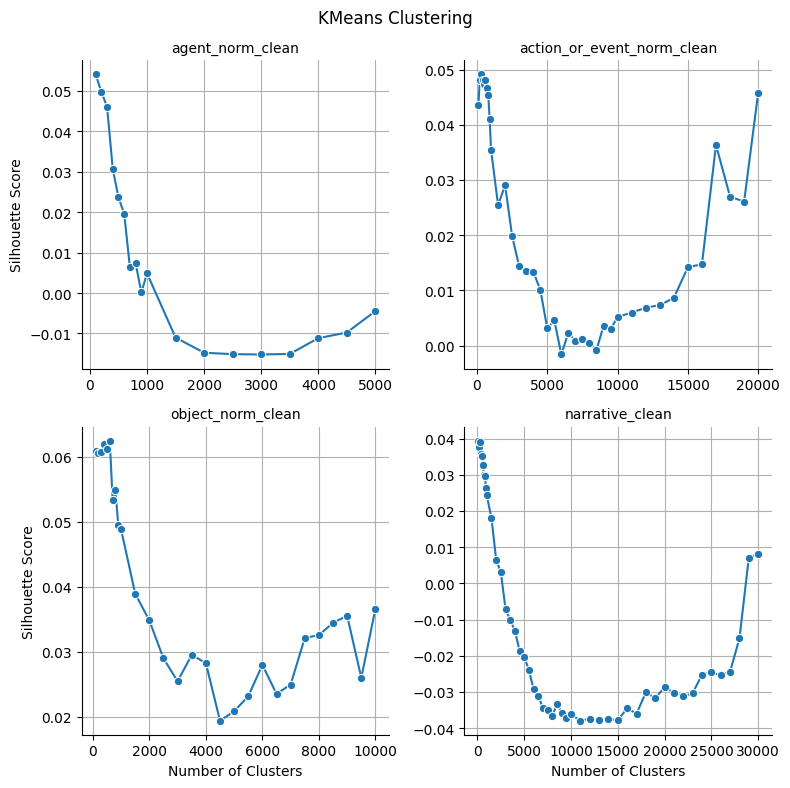

In [37]:
# Plot results
g = sns.FacetGrid(
    df_clustering_results,
    col="col", col_wrap=2,
    sharey=False, sharex=False, height=4
)
g.map_dataframe(
    sns.lineplot, x="n_clusters", y="ss", marker="o"
)
for ax in g.axes.flatten():
    ax.grid(True)

plt.suptitle('KMeans Clustering')

# Add titles and labels
g.set_axis_labels("Number of Clusters", "Silhouette Score")
g.set_titles(col_template="{col_name}")
g.tight_layout()

# plt.savefig('./assets/overall_clustering_scores_kmeans.png')

plt.show()

### Agglomerative

In [57]:
fnames = [
    # './data/scoring/clustering_scores_agglomerative.xlsx',
    # './data/scoring/clustering_scores_agglomerative_more.xlsx',
    # './data/scoring/clustering_scores_agglomerative_more_v2.xlsx',
    # './data/scoring/clustering_scores_agglomerative_more_v3.xlsx',
    # Rerunning _all version which replaces all above
    './data/scoring/clustering_scores_agglomerative_all.xlsx',
    './data/scoring/clustering_scores_agglomerative_agent_object_combined.xlsx'
]
dfs = []
for fname in fnames:
    dfs.append(pd.read_excel(fname))
df_clustering_results = pd.concat(dfs).reset_index(drop=True)
print(df_clustering_results.shape)
df_clustering_results[:3]

(170, 5)


,dataset,col,n_clusters,ss,labels
0,overall,agent_norm_clean,100,0.023870,[69 29 48 ... 92 67 0]
1,overall,agent_norm_clean,200,0.034688,[122 130 197 ... 186 32 55]
2,overall,agent_norm_clean,300,0.044958,[122 114 197 ... 22 5 2]


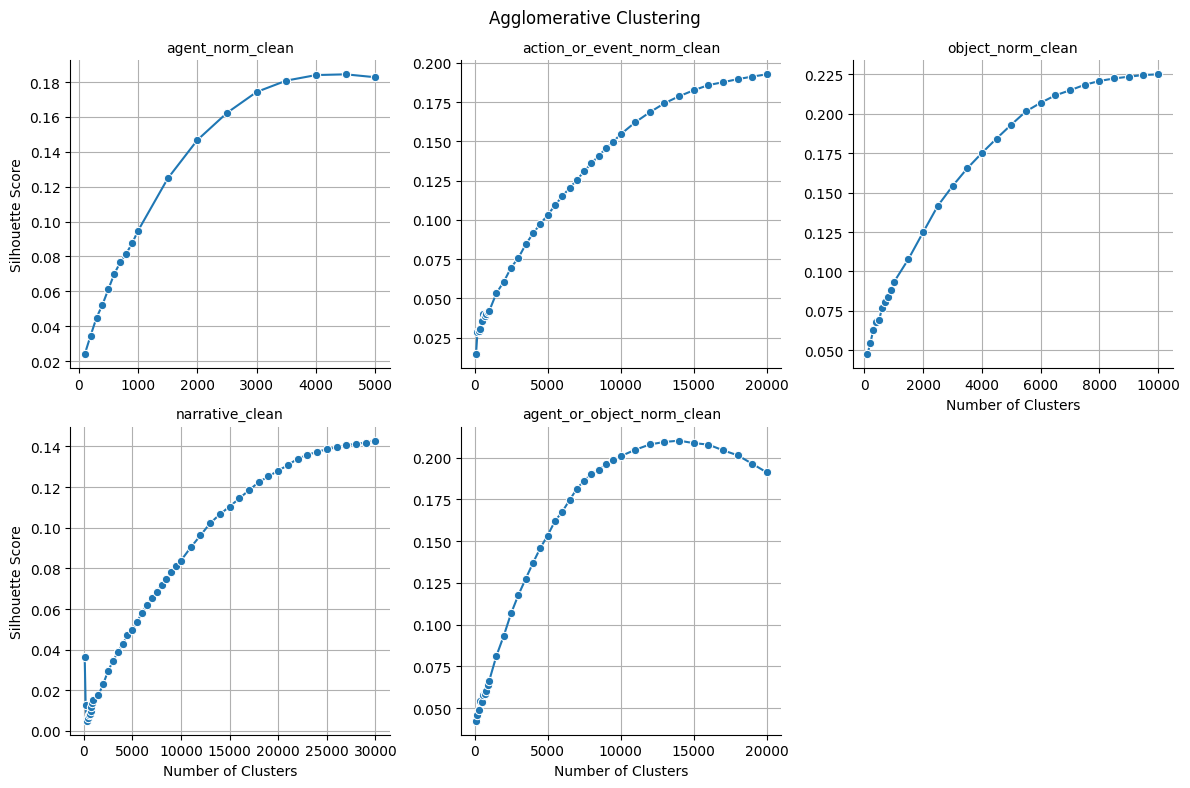

In [59]:
# Plot results
g = sns.FacetGrid(
    df_clustering_results,
    col="col", col_wrap=3,
    sharey=False, sharex=False, height=4
)
g.map_dataframe(
    sns.lineplot, x="n_clusters", y="ss", marker="o"
)
for ax in g.axes.flatten():
    ax.grid(True)

plt.suptitle('Agglomerative Clustering')

# Add titles and labels
g.set_axis_labels("Number of Clusters", "Silhouette Score")
g.set_titles(col_template="{col_name}")
g.tight_layout()

# plt.savefig('./assets/overall_clustering_scores_v2.png')

plt.show()

In [45]:
# df_clustering_results[
#     df_clustering_results['col'] == 'narrative_clean'
# ]

## Final clustering
Take best n_clusters (via the elbow test) and create clustering for the columns of interest.

In [ ]:
# Mapping from column name to best number of clusters
col2n_clusters = {
    'agent_norm_clean': 2_500,
    'action_or_event_norm_clean': 10_000,
    'object_norm_clean': 5_500,
    'narrative_clean': 13_000,
}

In [33]:
clustering_results = {
    'dataset': [],
    'col': [],
    'n_clusters': [],
    'ss': [],
    'labels': [],
}
for col, values in overall_col2values.items():
    print('Starting:', col)
    embeddings = model.encode(values, show_progress_bar=True)

    # Reduce embedding dimension to speed up distance computation
    pca = PCA(n_components=100, random_state=0)
    embeddings = pca.fit_transform(embeddings)

    # Compute cosine distance matrix (1 - similarity)
    sim_matrix = cosine_similarity(embeddings)
    sim_matrix = np.clip(sim_matrix, -1, 1)  # Clip to [-1, 1] to correct float approximations
    dist_matrix = 1 - sim_matrix

    silhouette_scores = []
    n_clusters = col2n_clusters[col]
    if n_clusters > len(values):
        # No point in clustering with more clusters than samples
        raise ValueError(f'n_clusters: {n_clusters} > # of samples: {len(values)}')
    clustering = AgglomerativeClustering(
        n_clusters=n_clusters,
        metric='precomputed',
        linkage='complete',
    )
    cluster_labels = clustering.fit_predict(dist_matrix)
    score = silhouette_score(dist_matrix, cluster_labels, metric="precomputed")

    clustering_results['dataset'].append('overall')
    clustering_results['col'].append(col)
    clustering_results['n_clusters'].append(n_clusters)
    clustering_results['ss'].append(score)
    clustering_results['labels'].append(cluster_labels)

    print(f"Clusters: {n_clusters}, Silhouette Score: {score:.4f}")

df_clustering_results = pd.DataFrame(clustering_results)
fname = './data/scoring/clustering_scores_agglomerative_best.xlsx'
df_clustering_results.to_excel(fname, index=False)
print('Wrote to:', fname)

Starting: agent_norm_clean


Batches: 100%|██████████| 319/319 [00:05<00:00, 55.91it/s]


Clusters: 3000, Silhouette Score: 0.1744
Starting: action_or_event_norm_clean


Batches: 100%|██████████| 1567/1567 [00:23<00:00, 67.17it/s]


Clusters: 10000, Silhouette Score: 0.1545
Starting: object_norm_clean


Batches: 100%|██████████| 697/697 [00:11<00:00, 59.08it/s]


Clusters: 5000, Silhouette Score: 0.1931
Starting: narrative_clean


Batches: 100%|██████████| 2541/2541 [00:58<00:00, 43.66it/s]


: 